#### 1.  Import Libraries and Setup

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


2024-11-11 13:46:45.465608: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-11 13:46:45.481673: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731332805.500966    9531 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731332805.506703    9531 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-11 13:46:45.526618: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

#### 2. Load and Preprocess Dataset

In [2]:
# Load dataset
data = pd.read_csv('LL_data.csv')
data['Received_Timestamp'] = pd.to_datetime(data['Received_Timestamp'])
data['Latitude'] = pd.to_numeric(data['Latitude'], errors='coerce')
data = data.dropna()
data.set_index('Received_Timestamp', inplace=True)

# Resample data to 6-hour intervals
data = data.resample('6H').mean()
data = data.interpolate(method='linear')

# Normalize the latitude data
scaler = MinMaxScaler()
data[['Latitude']] = scaler.fit_transform(data[['Latitude']])

# Split data into training and testing sets
training_set = data.loc['2023':'2024-02']
testing_set = data.loc['2024-03':]


/tmp/ipykernel_9531/2097030113.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = data.resample('6H').mean()


#### 3.  Sliding Window Processing

In [3]:
# Sliding window parameters
input_window_size = 28
output_window_size = 1
stride = 1

# Prepare data for sequence processing
X, y = [], []
for i in range(0, len(training_set) - input_window_size - output_window_size + 1, stride):
    input_window = training_set.iloc[i:i+input_window_size][['Latitude']]
    output_window = training_set.iloc[i+input_window_size:i+input_window_size+output_window_size][['Latitude']]
    X.append(input_window.values)
    y.append(output_window.values[-1])

# Convert lists to numpy arrays
X, y = np.array(X), np.array(y)

# Print shapes
print(f"Number of samples: {X.shape[0]}")
print(f"Input shape: {X.shape}, Target shape: {y.shape}")


Number of samples: 1672
Input shape: (1672, 28, 1), Target shape: (1672, 1)


#### 4.  BERT-based Model Architecture for Latitude Prediction

2024-11-11 13:48:21.593246: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 28, 64)         │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 28, 32)         │         2,080 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 28, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ get_item (GetItem)              │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,241 (8.75 KB)

 Trainable params: 2,241 (8.75 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.1777 - val_loss: 0.0052 - learning_rate: 0.0010
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0143 - val_loss: 0.0036 - learning_rate: 0.0010
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0119 - val_loss: 0.0038 - learning_rate: 0.0010
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0095 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0086 - val_loss: 0.0044 - learning_rate: 0.0010
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0085 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087 - val_loss: 0.0043 - learning_rate: 5.0000e-04
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 0.0045 - learning_rate: 5.0000e-04
Epoch 9/100
37/37 ━━━━━━━━━━━━━━━━━

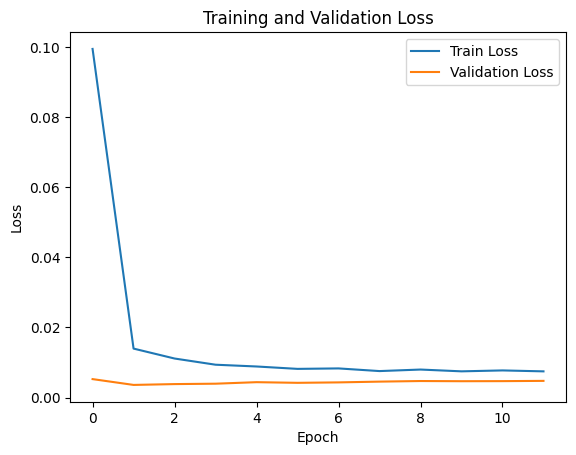

In [4]:
# Define BERT-like model architecture for latitude encoding and prediction
def build_geohash_bert_model(input_shape, units=64, dense_units=32, dropout_rate=0.2, learning_rate=0.001):
    inputs = Input(shape=input_shape)
    
    # BERT-styled dense layers for feature representation
    x = TimeDistributed(Dense(units, activation='relu'))(inputs)
    x = Dropout(dropout_rate)(x)
    
    # Embedding dense layers to capture spatial context
    x = TimeDistributed(Dense(units // 2, activation='relu'))(x)
    x = Dropout(dropout_rate)(x)
    
    # Final dense layer for latitude prediction
    outputs = Dense(1)(x[:, -1, :])  # Select last time step output for prediction
    
    # Compile model
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# Initialize model
input_shape = (input_window_size, 1)  # Each sequence has 28 time steps with 1 feature (Latitude)
model = build_geohash_bert_model(input_shape=input_shape)
print(model.summary())

# Early stopping and learning rate scheduling
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train model
history = model.fit(X, y, epochs=100, batch_size=32, validation_split=0.3, callbacks=[early_stopping, lr_scheduler], verbose=1)

# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


#### 5.  Prepare Testing Set

In [5]:
# Prepare testing set with the same sliding window approach
X_test, y_test = [], []
for i in range(0, len(testing_set) - input_window_size - output_window_size + 1, stride):
    input_window = testing_set.iloc[i:i+input_window_size][['Latitude']]
    output_window = testing_set.iloc[i+input_window_size:i+input_window_size+output_window_size][['Latitude']]
    X_test.append(input_window.values)
    y_test.append(output_window.values[-1])

X_test, y_test = np.array(X_test), np.array(y_test)
print(f"Number of test samples: {X_test.shape[0]}")
print(f"Test input shape: {X_test.shape}, Test target shape: {y_test.shape}")


Number of test samples: 648
Test input shape: (648, 28, 1), Test target shape: (648, 1)


#### 6. Test the Model

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step 
Mean Squared Error on the Testing Set: 0.010417004161240584


/tmp/ipykernel_9531/2327876158.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_set['Predicted_Latitude'] = np.nan


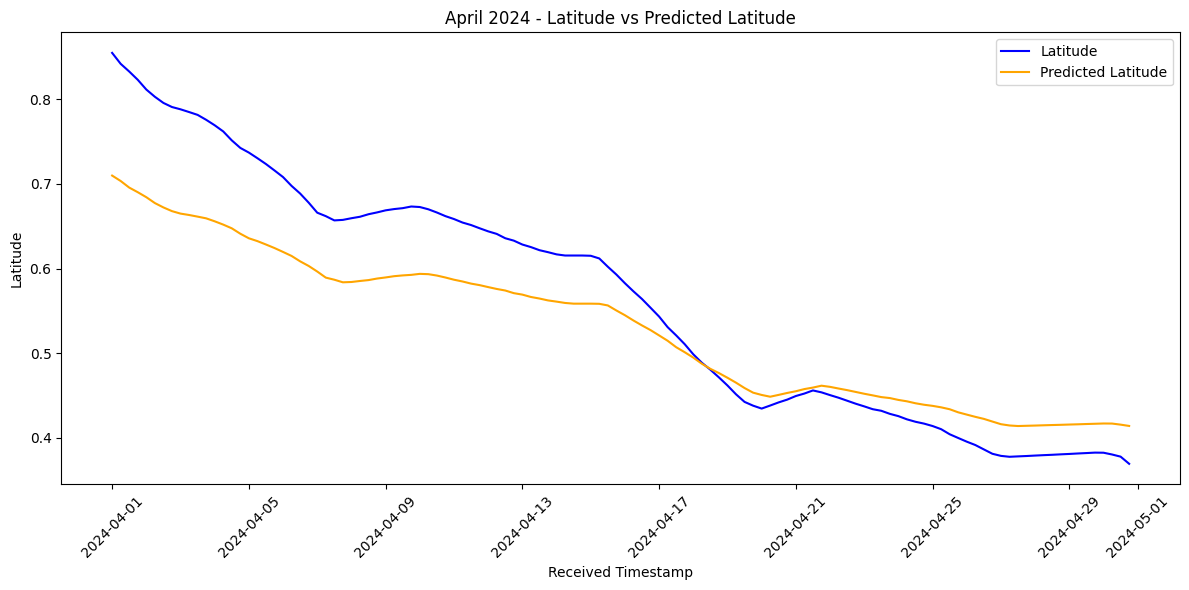

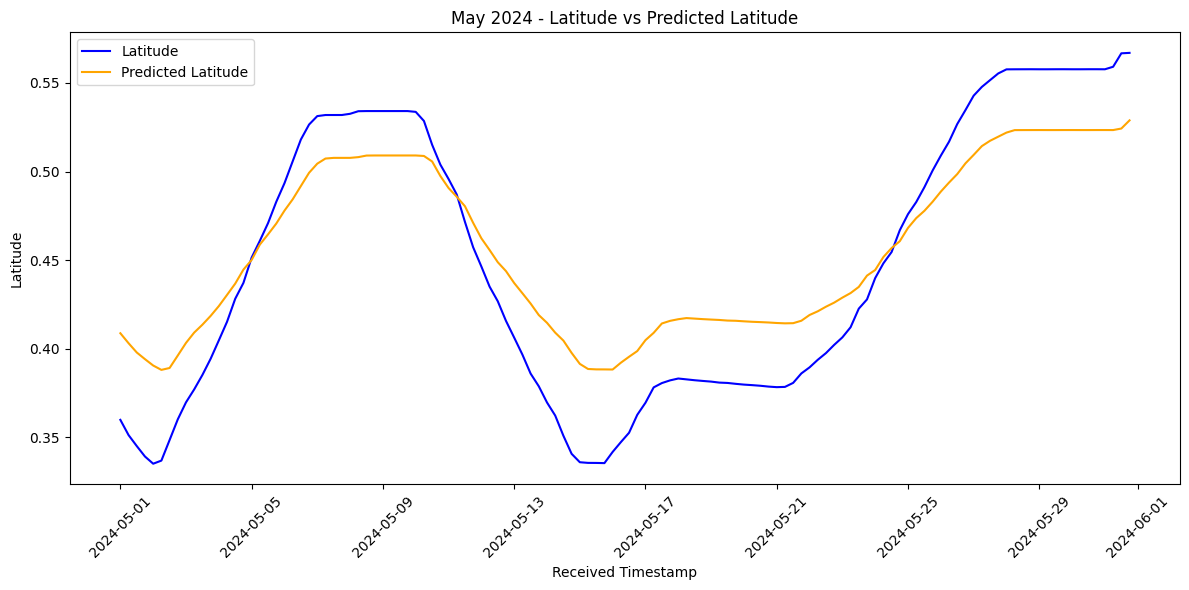

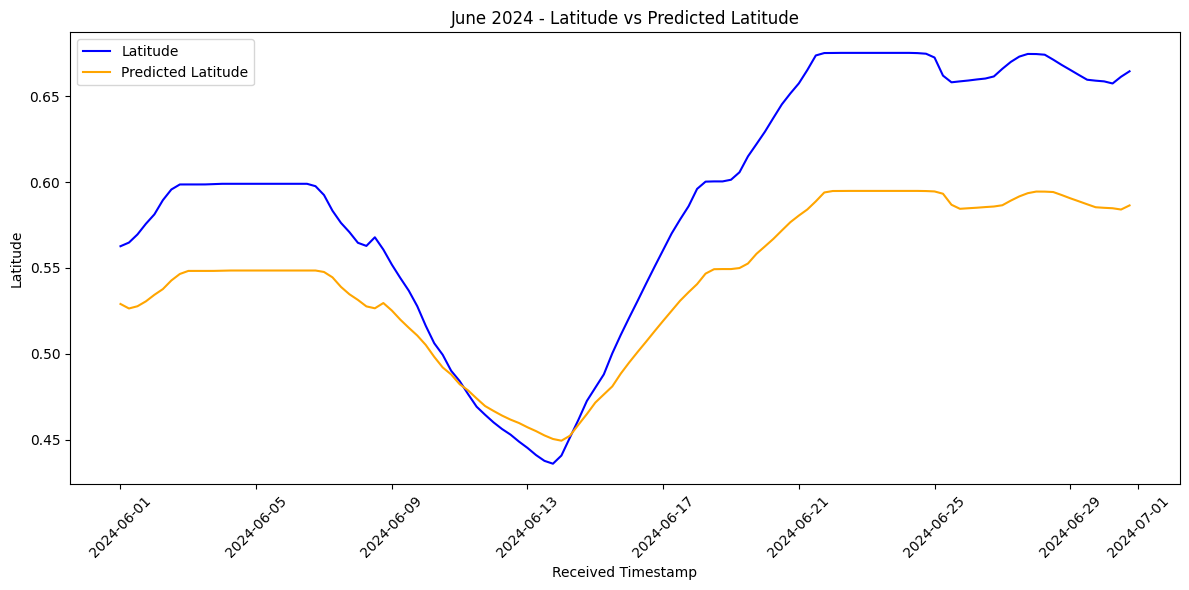

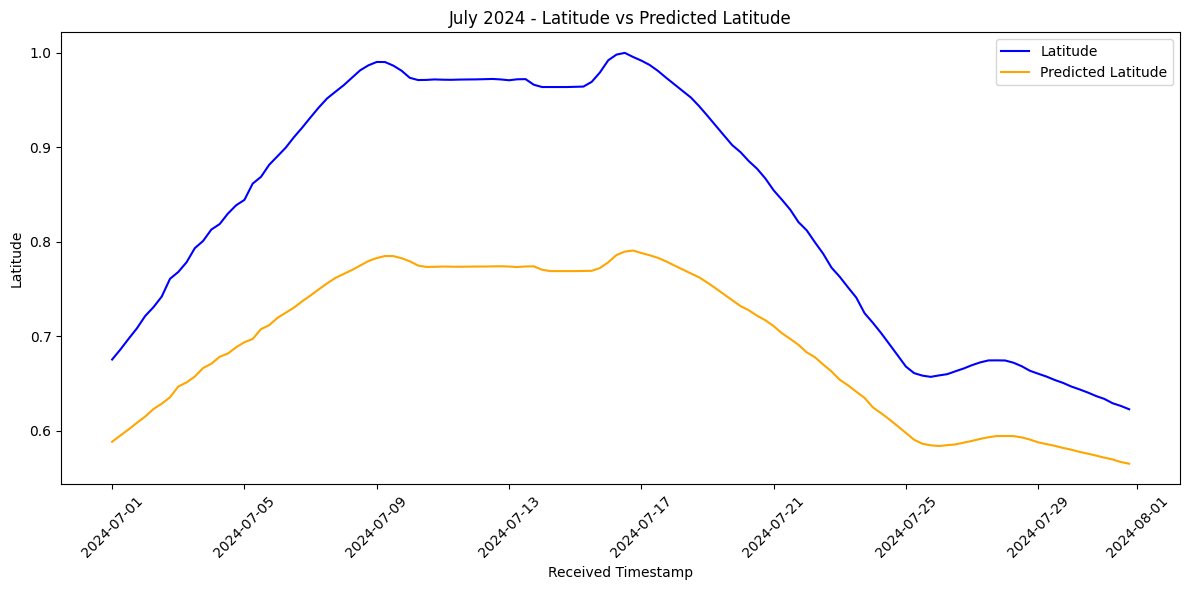

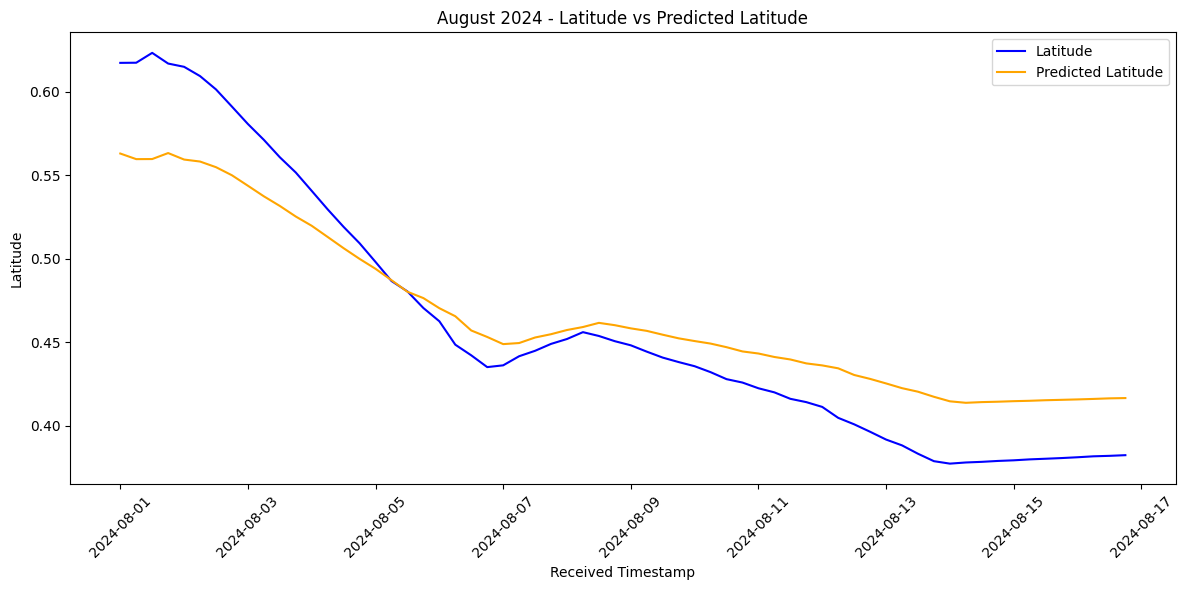

In [6]:
# Make predictions
y_pred = model.predict(X_test)

# Calculate mean squared error
error = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on the Testing Set: {error}")

# Integrate predictions into the testing set for visualization
predictions_df = pd.DataFrame(y_pred, columns=['Predicted_Latitude'])
testing_set['Predicted_Latitude'] = np.nan
testing_set.iloc[input_window_size:input_window_size + len(y_pred), -1] = predictions_df.values

# Plot results
months = {'April': '2024-04', 'May': '2024-05', 'June': '2024-06', 'July': '2024-07', 'August': '2024-08'}

for month_name, month_str in months.items():
    monthly_data = testing_set[testing_set.index.to_period('M') == month_str]
    
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_data.index, monthly_data['Latitude'], label='Latitude', color='blue')
    plt.plot(monthly_data.index, monthly_data['Predicted_Latitude'], label='Predicted Latitude', color='orange')
    plt.title(f'{month_name} 2024 - Latitude vs Predicted Latitude')
    plt.xlabel('Received Timestamp')
    plt.ylabel('Latitude')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
